In [1]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transform
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
def build_one_hot_vocab(input_text):
    vocab = set()
    input_text = input_text.str.lower()
    for word in input_text:
        vocab.add(word)
    vocab.add("<UNK>")
    return {token: i for i, token in enumerate(vocab)}


def one_hot_encode(input_text, vocab):
    vectorized_text = np.zeros(len(vocab))
    for word in input_text:
        if word in vocab:
            vectorized_text[vocab[word]] += 1
        else:
            vectorized_text[vocab["<UNK>"]] += 1
    return vectorized_text

def build_specialized_vocab(input_text):
    vocab = set()
    vocab.add("<UNK>")
    input_text = input_text.str.lower().astype(str)

    # Build vocabulary
    for text in input_text:
        for word in text.split(";"):
            word = word.strip()  # Remove extra spaces
            if word:
                vocab.add(word)

    return {token: i for i, token in enumerate(vocab)}


def vectorize_text(input_text, vocab):
    # Ensure the input is a string
    vectorized_text = np.zeros(len(vocab))
    for word in input_text.split(";"):
        if word in vocab:
            vectorized_text[vocab[word]] += 1
        else:
            vectorized_text[vocab["<UNK>"]] += 1
    return vectorized_text

### Converting csv to a PyTorch Dataset Object

In [3]:
def process_data(df, vocabs):
    """
    Processes a dataset file to encode categorical variables and convert data into PyTorch tensors.

    Args:
        file_path (str): Path to the CSV file

    Returns:
        tuple: A tuple containing:
        - features_tensor (torch.Tensor) : Tensor of features
        - labels_tensor (torch.Tensor) : Tensor of labels.
        - label_encoders (dict): Dictionary of LabelEncoders for categorical columns
    """
    print("processing data")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # drop useless data
    dropped_columns = ["id", "date"]
    df = df.drop(dropped_columns, axis=1)
    
    for col in ["statement", "justification", "speaker_description"]:
        df[col] = df[col].fillna("None").astype(str)
        df[col] = df[col].apply(lambda x: tokenizer.encode(x, padding='max_length', truncation=True, max_length=256))
        
    for col in ["subject", "state_info"]:
        df[col] = df[col].fillna("None").astype(str)
        df[col] = df[col].apply(lambda x: vectorize_text(x, vocabs[col]))
        
    for col in ["speaker", "context"]:
        df[col] = df[col].fillna("None").astype(str)
        df[col] = df[col].apply(lambda x: one_hot_encode(x, vocabs[col]))

    return df

def create_vocabs():
    df = pd.read_csv("data/train.csv")
    dropped_columns = ["id", "date"]
    df = df.drop(dropped_columns, axis=1)
    
    vocabs = {}
        
    for col in ["subject", "state_info"]:
        df[col] = df[col].fillna("None").astype(str)
        vocabs[col] = build_specialized_vocab(df[col])
        
    for col in ["speaker", "context"]:
        df[col] = df[col].fillna("None").astype(str)
        vocabs[col] = build_one_hot_vocab(df[col])
    return vocabs
    

In [4]:
class SentimentDataset(Dataset):
    def __init__(self, path, vocabs, transform=None):
        self.sentiment = pd.read_csv(path)
        self.sentiment = process_data(self.sentiment, vocabs)
        self.transform = transform
        
        
    def __len__(self):
        return len(self.sentiment)
    
    def __getitem__(self, idx):
        data = self.sentiment.iloc[idx]
        label = data["label"]
        data = data.drop("label")
        
        max_length = 0
        for col in data.index:
            value = data[col]
            if isinstance(value, (np.ndarray, list)):
                max_length = max(max_length, len(value))
        
        feature_vectors = []
        for col in data.index:
            value = data[col]
            if isinstance(value, (np.ndarray, list)):
                feature_vectors.append(np.array(value))
            else:
                feature_vectors.append(np.array([value], dtype=np.float32))

        feature_vectors = np.concatenate(feature_vectors)

        if self.transform:
            feature_vectors = self.transform(feature_vectors)
            
        return torch.tensor(feature_vectors, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
        

In [14]:
t = transform.Compose([transform.ToTensor()])
vocabs = create_vocabs()
train_dataset = SentimentDataset(path="data/train.csv", vocabs=vocabs)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
iterator = iter(dataloader)
data, label = next(iterator)

print(data.shape, label.shape)

processing data


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

torch.Size([1, 9638]) torch.Size([1])


### Training Neural Network

In [5]:
class FakeNewsClassifier(nn.Module):
    def __init__(self, input_dim=9638, num_classes=6):
        super(FakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

vocabs = create_vocabs()
train_dataset = SentimentDataset(path="data/train.csv", vocabs=vocabs)
test_dataset = SentimentDataset(path="data/test.csv", vocabs=vocabs)
val_dataset = SentimentDataset(path="data/valid.csv", vocabs=vocabs)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

processing data
processing data
processing data


Validating: 100%|██████████| 18/18 [00:02<00:00,  8.00its/s]


Epoch 1/10: Train Loss:  1.6183, Val Loss: 1.6022802922460768, Train Accuracy:  30.84, Val Accuracy:  31.26


Validating: 100%|██████████| 18/18 [00:02<00:00,  7.06its/s]


Epoch 2/10: Train Loss:  1.5377, Val Loss: 1.604605005847083, Train Accuracy:  36.01, Val Accuracy:  33.09


Validating: 100%|██████████| 18/18 [00:02<00:00,  6.39its/s]


Epoch 3/10: Train Loss:  1.4715, Val Loss: 1.632197188006507, Train Accuracy:  39.11, Val Accuracy:  32.39


Validating: 100%|██████████| 18/18 [00:02<00:00,  7.28its/s]


Epoch 4/10: Train Loss:  1.3791, Val Loss: 1.6812700629234314, Train Accuracy:  44.68, Val Accuracy:  29.82


Validating: 100%|██████████| 18/18 [00:02<00:00,  7.49its/s]


Epoch 5/10: Train Loss:  1.2482, Val Loss: 1.7835679319169786, Train Accuracy:  50.88, Val Accuracy:  29.73


Validating: 100%|██████████| 18/18 [00:02<00:00,  6.69its/s]


Epoch 6/10: Train Loss:  1.0683, Val Loss: 1.9988443851470947, Train Accuracy:  59.32, Val Accuracy:  28.12


Validating: 100%|██████████| 18/18 [00:02<00:00,  7.14its/s]


Epoch 7/10: Train Loss:  0.8673, Val Loss: 2.2010342677434287, Train Accuracy:  67.88, Val Accuracy:  29.91


Validating: 100%|██████████| 18/18 [00:02<00:00,  7.32its/s]


Epoch 8/10: Train Loss:  0.6733, Val Loss: 2.494113564491272, Train Accuracy:  75.50, Val Accuracy:  26.82


Validating: 100%|██████████| 18/18 [00:02<00:00,  6.87its/s]


Epoch 9/10: Train Loss:  0.5242, Val Loss: 2.7453805605570474, Train Accuracy:  80.97, Val Accuracy:  27.47


Validating: 100%|██████████| 18/18 [00:02<00:00,  7.11its/s]


Epoch 10/10: Train Loss:  0.4101, Val Loss: 3.0990865892834134, Train Accuracy:  85.44, Val Accuracy:  27.95


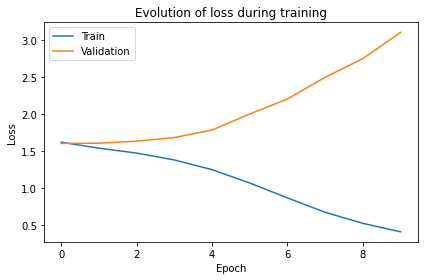

In [7]:
model = FakeNewsClassifier().to(device)
optimizer = Adam(model.parameters(), lr=.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

epochs = 10
training_losses = []
val_losses = []
for epoch in range(1, epochs + 1):
    train_loss = 0
    val_loss = 0
    train_correct_predictions = 0
    train_total_samples = 0
    val_correct_predictions = 0
    val_total_samples = 0
    
    model.train()
    for features, labels in tqdm(train_loader, desc="Training", unit="its"):
        features = features.to(device).float()
        labels = labels.to(device).long()
        
        optimizer.zero_grad()
        outputs = model(features)
        t_loss = criterion(outputs, labels)
        t_loss.backward()
        optimizer.step()
        
        train_loss += t_loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        train_correct_predictions += (predicted == labels).sum().item()
        train_total_samples += labels.size(0)
        
    model.eval()
    for features, labels in tqdm(val_loader, desc="Validating", unit="its"):
        features = features.to(device).float()
        labels = labels.to(device).long()
        with torch.no_grad():
            outputs = model(features)
            v_loss = criterion(outputs, labels)
        
        val_loss += v_loss.item()
        _, predicted = torch.max(outputs, 1)
        val_correct_predictions += (predicted == labels).sum().item()
        val_total_samples += labels.size(0)
        
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy = train_correct_predictions / train_total_samples * 100
    val_accuracy = val_correct_predictions / val_total_samples * 100
    print(f"Epoch {epoch}/{epochs}: Train Loss: {train_loss: .4f}, Val Loss: {val_loss}, Train Accuracy: {train_accuracy: .2f}, Val Accuracy: {val_accuracy: .2f}")
    
torch.save(model.state_dict(), "trained_model.pth")

plt.plot(np.arange(epochs), training_losses, label="Train")
plt.plot(np.arange(epochs), val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolution of loss during training")
plt.legend()
plt.tight_layout()
plt.show()

Testing: 100%|██████████| 18/18 [00:02<00:00,  7.59batch/s]


Accuracy: 0.2844
Precision: 0.2846
Recall: 0.2844
F1 Score: 0.2831

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.20      0.22       303
           1       0.45      0.45      0.45       660
           2       0.21      0.20      0.21       360
           3       0.21      0.28      0.24       371
           4       0.22      0.22      0.22       343
           5       0.19      0.16      0.17       259

    accuracy                           0.28      2296
   macro avg       0.26      0.25      0.25      2296
weighted avg       0.28      0.28      0.28      2296



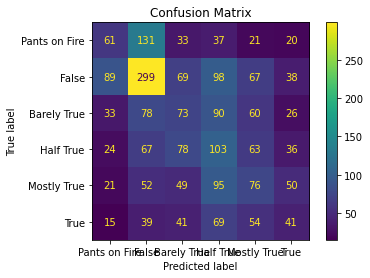

In [9]:
test_model = FakeNewsClassifier().to(device)
test_model.load_state_dict(torch.load("trained_model.pth"))
test_model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for features, labels in tqdm(test_loader, desc="Testing", unit="batch"):
        features = features.to(device).float()
        labels = labels.to(device).long()
        
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))

corresponding_labels = ["Pants on Fire", "False", "Barely True", "Half True", "Mostly True", "True"]
ConfusionMatrixDisplay.from_predictions(all_labels, all_predictions, display_labels=corresponding_labels)
plt.title("Confusion Matrix")
plt.savefig("results/test_confusion_matrix.png")
plt.show()